## agent to search + fetch data from CDC

```
## input
user: "give me a time series of covid 19 hospitalizations in 2023"

## agentic processing
# 1. searches cdc
# 2. reviews search results
# 3. downloads relevant data
# 4. preprocesses data
# 5. plots

## output
pd.DataFrame[x=date, y=covid_19_hospitalizations]
```

## setup

In [2]:
import os
import subprocess
import dotenv
from pathlib import Path

# autoreload any .py scripts
%load_ext autoreload
%autoreload 2

# set the project's root directory as the notebooks' working directory
git_root = subprocess.run(
    ["git", "rev-parse", "--show-toplevel"], capture_output=True, text=True
).stdout.strip()

os.chdir(git_root)
print(git_root)

env_path = Path(git_root, "backend")
print(env_path)

from dotenv import load_dotenv

load_dotenv()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/Users/nilsgandlau/code/hackathon-dc-aegis
/Users/nilsgandlau/code/hackathon-dc-aegis/backend


True

In [3]:
from typing import Any
import outlines
from src.utils import search_cdc_datasets, simplify_search_results, call_claude, prompt_review_search_results

## user inpu
disease: str = "covid 19 hospitalizations"
user_query: str = f"looking for data on {disease} in 2025"

## searching CDC datasets
search_query: str = f"{disease}" # can be generated by an LLM
search_results: list[dict[dict[str, Any]]] = search_cdc_datasets(search_query, limit=10)
simplified_search_results: list[dict] = simplify_search_results(search_results)

## Evaluating search results by LLM/AGENT
user_prompt: str = prompt_review_search_results(
    simplified_search_results=simplified_search_results,
    user_query=user_query,
)
# print(user_prompt)
print("--------------------------------")
llm_answer: str = call_claude(user_prompt)
print(llm_answer)

--------------------------------
I've analyzed the datasets to determine which ones can help answer the question about COVID-19 hospitalization data in 2025. Here are the relevant datasets:

* **dataset <id>6jg4-xsqq</id>**: 
  * This dataset contains COVID-19 Hospitalization Surveillance Network (COVID-NET) data
  * It was most recently updated on May 29, 2025
  * The description indicates it's actively maintained and "updated weekly"
  * Contains hospitalization rates showing how many people in surveillance areas are hospitalized with COVID-19

* **dataset <id>cf5u-bm9w</id>**:
  * Also contains COVID-NET surveillance data for COVID-19 hospitalizations
  * Last updated on May 29, 2025
  * Provides monthly hospitalization rates
  * Includes demographic breakdowns (age, race, sex)

* **dataset <id>bigw-pgk2</id>**:
  * Contains COVID-NET hospitalization surveillance data
  * Updated on May 29, 2025
  * Includes detailed patient data like ICU admissions, mechanical ventilation, and outc

In [5]:
from src.llm_utils import extract_text_inside_xml_tags, extract_xml_tags_from_text
from src.utils import download_dataset, get_llm_digestable_dataset_preview

num_relevant_datasets = len(extract_xml_tags_from_text(llm_answer))
relevant_dataset_ids = extract_text_inside_xml_tags(llm_answer, "id")
print(f"relevant_dataset_ids: {relevant_dataset_ids}")

# download each dataset
example_id = relevant_dataset_ids[0]
example_id = "cf5u-bm9w"
df = download_dataset(example_id)
dataset_preview = get_llm_digestable_dataset_preview(df)
print(dataset_preview)

relevant_dataset_ids: ['6jg4-xsqq', 'cf5u-bm9w', 'bigw-pgk2', 'q3t8-zr7t']
| state   | season   |   _yearmonth | agecategory_legend   | sex_label   | race_label   |   monthlyrate | type       |
|---------|----------|--------------|----------------------|-------------|--------------|---------------|------------|
| Utah    | 2021-22  |       202205 | 6mo-<12 months       | All         | All          |          26.5 | Crude Rate |
| Utah    | 2021-22  |       202209 | 6mo-<12 months       | All         | All          |          14.8 | Crude Rate |
| Utah    | 2021-22  |       202204 | 6mo-<12 months       | All         | All          |           0   | Crude Rate |
| Utah    | 2021-22  |       202203 | 6mo-<12 months       | All         | All          |          53   | Crude Rate |
| Utah    | 2021-22  |       202202 | 6mo-<12 months       | All         | All          |          53   | Crude Rate |

|   _yearmonth |   monthlyrate |
|--------------|---------------|
|    1000      |      980

In [6]:
# feed preview of dataset to LLM to see if it can be used for user query
from typing import Literal
from src.utils import prompt_template_check_data_preview


prompt = prompt_template_check_data_preview(dataset_preview=dataset_preview, user_query=user_query)
llm_answer = call_claude(prompt)
llm_short_answer: Literal["yes", "no"] = extract_text_inside_xml_tags(llm_answer, "answer")
print(f"LLM short answer: {llm_short_answer}\n--------------------------------")
print(f"LLM full answer: {llm_answer}")

LLM short answer: ['no']
--------------------------------
LLM full answer: Based on the dataset preview, I can analyze whether this data can answer a query about COVID-19 hospitalizations in 2025.

Looking at the data:
1. The dataset appears to contain health-related information with monthly rates by state, age category, sex, and race
2. The time periods shown in the `_yearmonth` column range from values like 202110, 202112, 202204, etc., which represent months in 2021 and 2022
3. The "season" column shows "2021-22" which further confirms the time range
4. The latest date visible in the preview is 202209 (September 2022)
5. There are no column labels explicitly mentioning "COVID-19" or "hospitalizations"
6. There is no data for 2025 (which would be represented as values like 202501, 202502, etc.)

While this appears to be health-related data that might include disease rates, there are two key issues:
1. The data does not clearly indicate it's about COVID-19 hospitalizations specificall

In [7]:
# preprocess dataset
from src.utils import prompt_template_prep_data


prompt = prompt_template_prep_data(dataset_preview=dataset_preview, user_query=user_query)
llm_answer: str = call_claude(prompt)
print(llm_answer)

```python
import pandas as pd
import numpy as np

# Check that yearmonth column is numeric
df['_yearmonth'] = pd.to_numeric(df['_yearmonth'], errors='coerce')

# Filter out invalid yearmonth values (ensure they're in valid format YYYYMM)
df = df[df['_yearmonth'].notnull() & (df['_yearmonth'] >= 100000) & (df['_yearmonth'] <= 999999)]

# Convert yearmonth to datetime
df['date'] = pd.to_datetime(df['_yearmonth'].astype(str).str[:4] + '-' + 
                            df['_yearmonth'].astype(str).str[4:6] + '-01')

# Select relevant columns
df_clean = df[['date', 'monthlyrate']].copy()

# Rename the column to be more descriptive
df_clean = df_clean.rename(columns={'monthlyrate': 'covid_hospitalization_rate'})

# Sort by date
df_clean = df_clean.sort_values('date')

# The user is looking for 2025 data, but the dataset doesn't appear to have it
# Create a message to indicate this
if not any(df_clean['date'].dt.year == 2025):
    print("Note: The dataset does not contain COVID-19 hospitaliz

In [9]:
from src.utils import strip_code_block, execute_code_block

code = strip_code_block(llm_answer)
df_clean   = execute_code_block(code, df)
df_clean.head()

Note: The dataset does not contain COVID-19 hospitalization data for 2025.


,date,covid_hospitalization_rate
384,2021-10-01,130.4
246,2021-10-01,7.7
662,2021-10-01,2.8
69,2021-10-01,46.6
239,2021-10-01,6.5


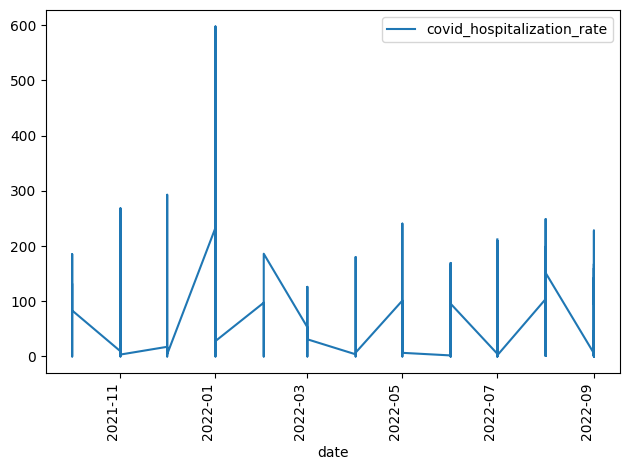

In [10]:
from src.utils import plot_time_series


plot_time_series(df_clean, "number of covid 19 cases")